This Jupyter notebook loads the raw amplitude and Mel spectrogram data files as numpy arrays.

Download the data files [here](https://console.cloud.google.com/storage/browser/cs181_practical_data).  This notebook assumes that the data files as located in the same directory.

In [127]:
# Overall note for graders: We weren't able to push the data files to Github, but when we were running 
# this notebook locally, the data was located in the same directory as this notebook.

import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score # takes into account class sizes 
import torch
import pandas as pd

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print (device)

cpu


### Load raw amplitude data.

In [129]:
# Load train data

X_amp_train = np.load("Xtrain_amp.npy")
y_amp_train = np.load("ytrain_amp.npy")

In [130]:
X_amp_train.shape

(5553, 44100)

In [131]:
# Load test data

X_amp_test = np.load("Xtest_amp.npy")
y_amp_test = np.load("ytest_amp.npy")

In [132]:
X_amp_test.shape

(2197, 44100)

### Load Mel spectrogram data.

In [133]:
# Load train data

X_mel_train = np.load("Xtrain_mel.npy")
y_mel_train = np.load("ytrain_mel.npy")

In [134]:
X_mel_train.shape

(5553, 128, 87)

In [135]:
# Flatten X_mel_train's spectrogram features
X_mel_train_flat = X_mel_train.reshape(X_mel_train.shape[0], -1)
X_mel_train_flat.shape

(5553, 11136)

In [136]:
# Load test data

X_mel_test = np.load("Xtest_mel.npy")
y_mel_test = np.load("ytest_mel.npy")

In [137]:
X_mel_test.shape

(2197, 128, 87)

## Part A

#### Perform PCA on raw amplitude features
Compute a dimensionality reduction on the Xtrain_amp dataset and on the Xtest_amp dataset. This will allow us to not overload our model when training a logistic regression model with noisy data and only keep the 500 most significant components, which capture most of the variation.

### Make some exploratory plots of the data

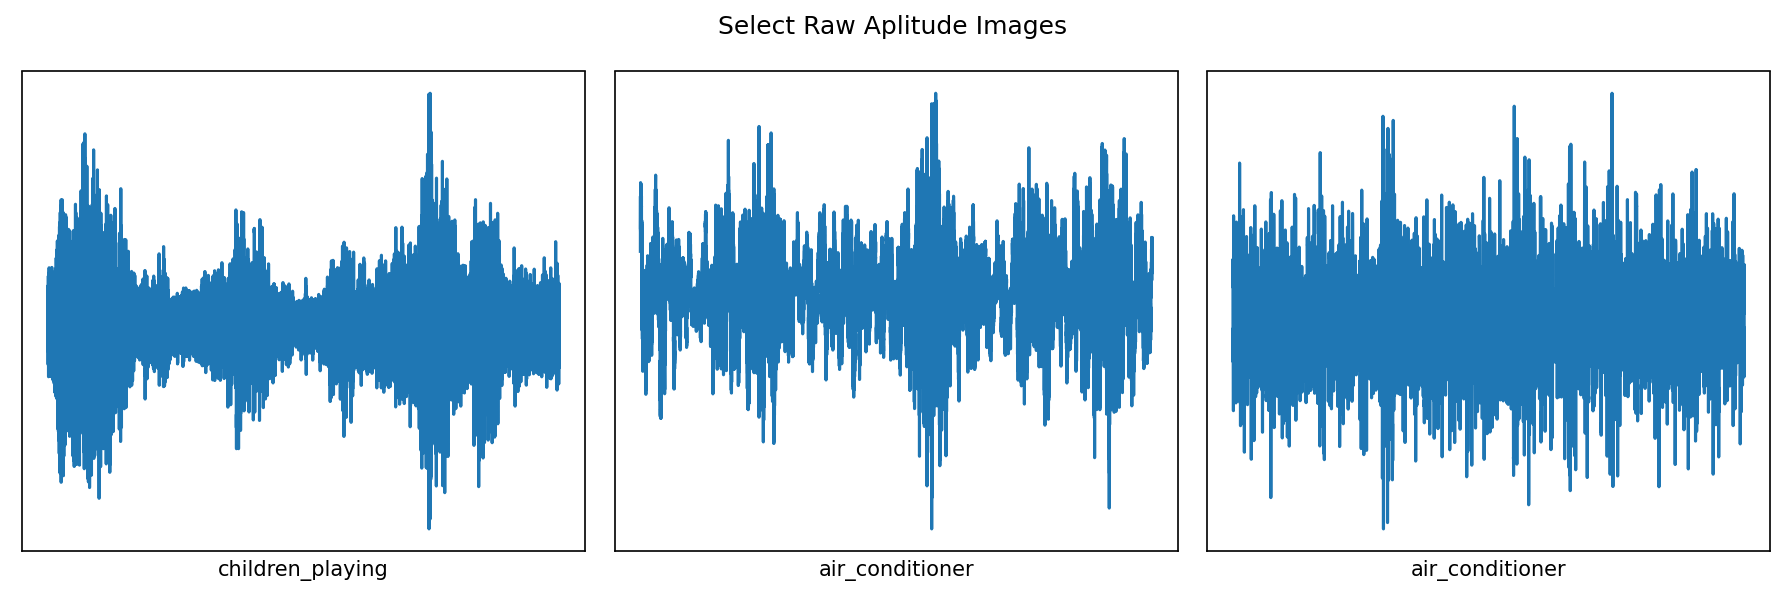

In [138]:
# Make a plot of some of the raw frequencies so that we can explore the data
plt.figure(dpi=150, figsize=(12,4))
for i in range(3):
    
    # create our subplot
    plt.subplot(1,3,i+1)
    
    # plot our image
    plt.plot(X_amp_train[i])
    
    # put our word label based on the 0 or 1
    if y_amp_train[i] == 0:
        plt.xlabel("air_conditioner")
    elif y_amp_train[i] == 1:
        plt.xlabel("car_horn")
    elif y_amp_train[i] == 2:
        plt.xlabel("children_playing")
    elif y_amp_train[i] == 3:
        plt.xlabel("dog_bark")
    elif y_amp_train[i] == 4:
        plt.xlabel("drilling")
    elif y_amp_train[i] == 5:
        plt.xlabel("engine_idling")
    elif y_amp_train[i] == 6:
        plt.xlabel("gun_shot")
    elif y_amp_train[i] == 7:
        plt.xlabel("jackhammer")
    elif y_amp_train[i] == 8:
        plt.xlabel("siren")
    else:
        plt.xlabel("street_music")
        
    # beautify
    plt.xticks([])
    plt.yticks([])
    
# more beautifying
plt.suptitle("Select Raw Aplitude Images")
plt.tight_layout()
plt.show()

### Train a logistic regression model on the 500 most significant PCA components.

In [139]:
# create our PCA object that will calculate the first two components.
pca = PCA(n_components=500)

# fit our PCA to the training data, and transform our data into its 500-dimensional representation
# only want to fit to training data, we should not be getting any extra information from our test set
Xtrain_amp_pca = pca.fit_transform(X_amp_train)

# let's check the shape of our lower dim representation
print(f"Lower-Dim PCA Representation Train Data Shape: {Xtrain_amp_pca.shape}")


Lower-Dim PCA Representation Train Data Shape: (5553, 500)


#### Visualize the first two components of the PCA to see what is being captured in the lower dimension

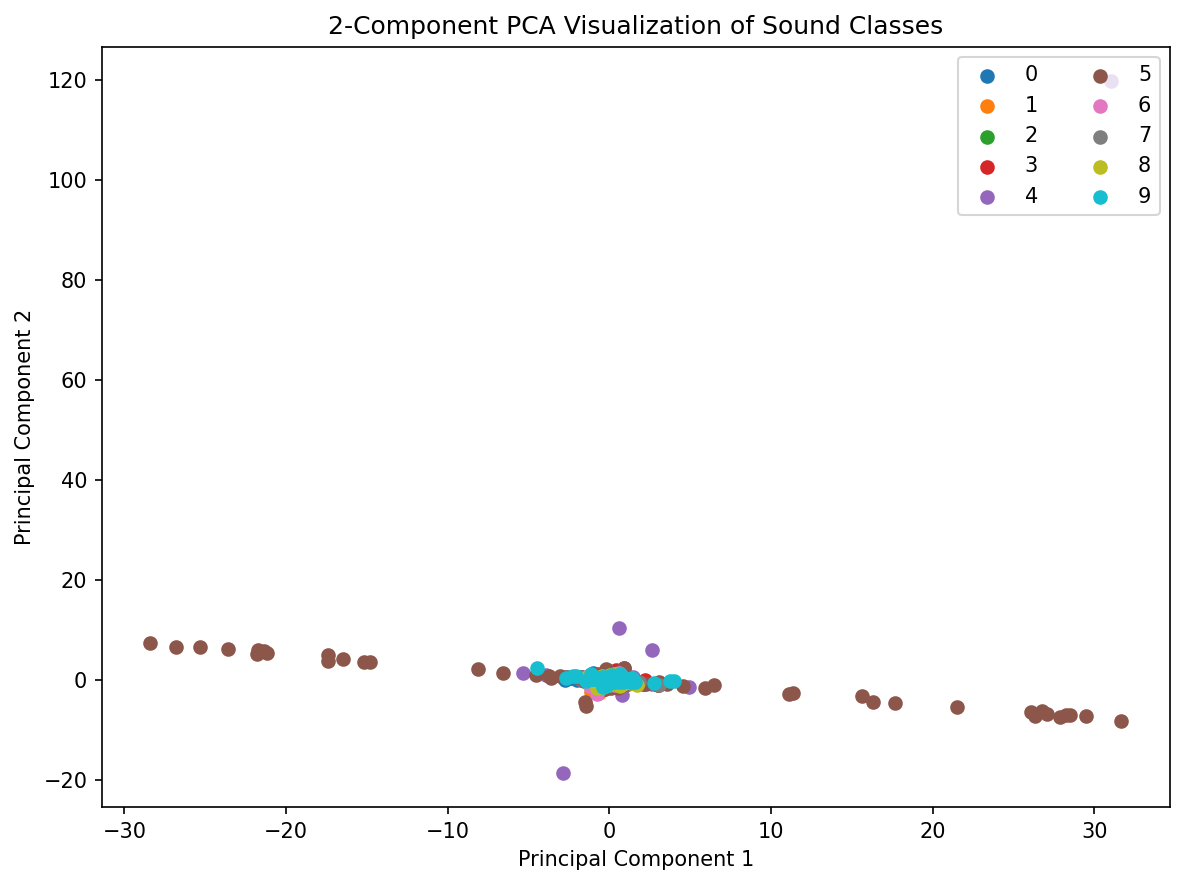

In [140]:
# scatter plot the two components just to see if the data is separable by eye
plt.figure(dpi=150, figsize=(8,6))

# iterate through all the digits
for sound_class in range(10):
    
    # get the samples that correspond to this digit
    samples = Xtrain_amp_pca[y_amp_train == sound_class]
    
    # scatter plot the first two PCA component
    plt.scatter(samples[:,0], samples[:,1], label=str(sound_class))

# beautify
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="upper right", ncol=2)
plt.title("2-Component PCA Visualization of Sound Classes")
plt.tight_layout()

plt.savefig('pca_two_components.png')
plt.show()

In [141]:
# create our LogisticRegression classifier
lr_pca = LogisticRegression()


# fit our SVM model
lr_pca.fit(Xtrain_amp_pca, y_amp_train)

# scale our testing X into a lower dimension
# Xtest_amp_pca = pca.fit_transform(X_amp_test)
Xtest_amp_pca = pca.transform(X_amp_test)

# make our predictions          
lr_preds = lr_pca.predict(Xtest_amp_pca)
          
# calculate + display our accuracy
lr_accuracy = np.mean(y_amp_test == lr_preds)
print("Accuracy: ", lr_accuracy)


# calculate and report: precision, recall, f1, support
target_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
print(classification_report(y_amp_test, lr_preds, target_names=target_names))

# calculate balanced accuracy, taking into account class sizes
print("Balanced Accuracy: ", round(balanced_accuracy_score(y_amp_test, lr_preds), 3))

/Users/alyssahuang/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.19253527537551207
                  precision    recall  f1-score   support

 air_conditioner       0.25      0.23      0.24       300
        car_horn       0.04      0.03      0.03        39
children_playing       0.25      0.58      0.34       299
        dog_bark       0.18      0.07      0.10       229
        drilling       0.15      0.09      0.11       264
   engine_idling       0.15      0.14      0.14       264
        gun_shot       0.29      0.07      0.11        30
      jackhammer       0.10      0.10      0.10       236
           siren       0.14      0.11      0.12       236
    street_music       0.20      0.17      0.19       300

        accuracy                           0.19      2197
       macro avg       0.17      0.16      0.15      2197
    weighted avg       0.18      0.19      0.17      2197

Balanced Accuracy:  0.158


### Perform PCA on the Mel spectogram features
Train a logistic regression model on the 500 most significant PCA components

In [142]:
# flatten the dataset, since SVM cannot take into account matrices
lr_pca = LogisticRegression()
Xtrain_mel_flattened = X_mel_train.reshape(X_mel_train.shape[0], -1)
Xtest_mel_flattened = X_mel_test.reshape(X_mel_test.shape[0], -1)

# transform the dataset using PCA
Xtrain_mel_pca = pca.fit_transform(Xtrain_mel_flattened)

# fit the logistic regression model on the lower dimensional training data
lr_pca.fit(Xtrain_mel_pca, y_mel_train)

# transform our test dataset into a lower dimension
# Xtest_mel_pca = pca.fit_transform(Xtest_mel_flattened)
Xtest_mel_pca = pca.transform(Xtest_mel_flattened)

# make predictions for our test dataset from our Logistic regression fit on our train data
preds_mel = lr_pca.predict(Xtest_mel_pca)

# print the accuracy
print(f"Accuracy: {np.mean(preds_mel == y_mel_test)}")

# calculate and report: precision, recall, f1, support
target_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
print(classification_report(y_mel_test, preds_mel, target_names=target_names))

# calculate balanced accuracy, taking into account class sizes
print("Balanced Accuracy: ", round(balanced_accuracy_score(y_mel_test, preds_mel), 3))

/Users/alyssahuang/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.33136094674556216
                  precision    recall  f1-score   support

 air_conditioner       0.19      0.18      0.19       300
        car_horn       0.42      0.49      0.45        39
children_playing       0.30      0.70      0.42       299
        dog_bark       0.42      0.23      0.30       229
        drilling       0.32      0.35      0.34       264
   engine_idling       0.44      0.35      0.39       264
        gun_shot       0.44      0.40      0.42        30
      jackhammer       0.18      0.11      0.14       236
           siren       0.55      0.49      0.52       236
    street_music       0.32      0.19      0.24       300

        accuracy                           0.33      2197
       macro avg       0.36      0.35      0.34      2197
    weighted avg       0.34      0.33      0.32      2197

Balanced Accuracy:  0.348


## Part B

### B1: First Step
Train at least one nonlinear model on a feature representation of your choice

In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

In [144]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### First Model: Neural Network

### Neural Network on Amp

In [145]:
# create a model for amp data
# select the hyperparameters we think appropriate

# change from 441 to 4410
model = nn.Sequential(
    nn.Linear(in_features=44100, out_features=441),
    nn.ReLU(),
    nn.Linear(in_features=441, out_features=10),
)

In [146]:
# tell PyTorch to not track gradients
with torch.no_grad():
    
    # convert our input data to a float tensor
    # cannot pass numpy array into pytorch, have to BOTH introduce with torch.tensor but ALSO
    # have to convert to float
    inputs = torch.tensor(X_amp_test).float()
    
    # pass our inputs straight into the model
    preds = model(inputs)
    
    # determine what shape the predictions are so we know what to do with them
    print(f"Shape of preds: {preds.shape}")


    # no need to softmax the output since we will just take the argmax
    # argmax and softmax would have the same highest value
    preds = preds.argmax(1)
    
    # check test accuracy
    print(f"test accuracy: {torch.sum(preds == torch.tensor(y_amp_test)) / y_amp_test.shape[0]}")
    


Shape of preds: torch.Size([2197, 10])
test accuracy: 0.12289485335350037


In [147]:
# moving the model to right device
model.to(device)

# specify loss function
loss_func = nn.CrossEntropyLoss()

# define our optimizer 
# increasing lr from 1e-3 to 1e-1, then to 1e-5
# decreased weight decay to 1e-1
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [148]:
# metrics we want to collect
train_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
test_loss_list = []


# train for a given number of epochs
for epoch in tqdm.tqdm(range(20), desc="Epoch"):
        
    # get our input imgs and labels. We have to convert from NumPy (original) to torch.tensors()
    # PyTorch expects inputs as floats, and labels as longs (i.e., high-memory integers)
    inputs = torch.tensor(X_amp_train).float()
    labels = torch.tensor(y_amp_train).long()
    
    # move our inputs and labels to the right device.
    inputs, labels = inputs.to(device), labels.to(device)

    # reset the gradient 
    optimizer.zero_grad()
    
    # compute our forward propogation
    # outputs are not softmaxed
    outputs = model(inputs) 
    
    # calculate the cross-entropy loss
    # this automatically applies softmax
    loss = loss_func(outputs, labels) 
    
    # calculate backpropogation
    # takes the gradient of the loss function w.r.t. all the parameters
    loss.backward() 
    
    # make a small step update to our parameters
    optimizer.step() 
    

    # update our train_loss
    # only inclue the .item() to extract the pure value from the tensor
    train_loss_list.append(loss.item()) 

    # calculate + record our train + test accuracy. 
    # we have finished training here, only taking eval metrics
    with torch.no_grad():

        # get our predictions with the current weights
        # we only want the indices, not the values
        _, predicted = torch.max(outputs.data, 1)
        
        # get our train accuracy
        train_accuracy = torch.sum(predicted == labels) / labels.size(0)
        
        # add to our list of accuracies
        train_accuracy_list.append(train_accuracy)
            
        # get our test inputs and labels same process as earlier
        test_inputs = torch.tensor(X_amp_test).float()
        test_labels = torch.tensor(y_amp_test).long()

        # move to the right device
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        # run our test set inputs through the network
        test_outputs = model(test_inputs)

        # get our test_loss
        test_loss = loss_func(test_outputs, test_labels)

        # record our test_loss
        # .item() tells pytorch we only want the value
        test_loss_list.append(test_loss.item())

        # make our predictions based on max
        _, test_predicted = torch.max(test_outputs.data, 1)

        # get our train accuracy
        test_accuracy = torch.sum(test_predicted == test_labels) / test_labels.size(0)
        
        # add to our list
        test_accuracy_list.append(test_accuracy)

Epoch: 100%|████████████████████████████████████| 20/20 [02:05<00:00,  6.29s/it]


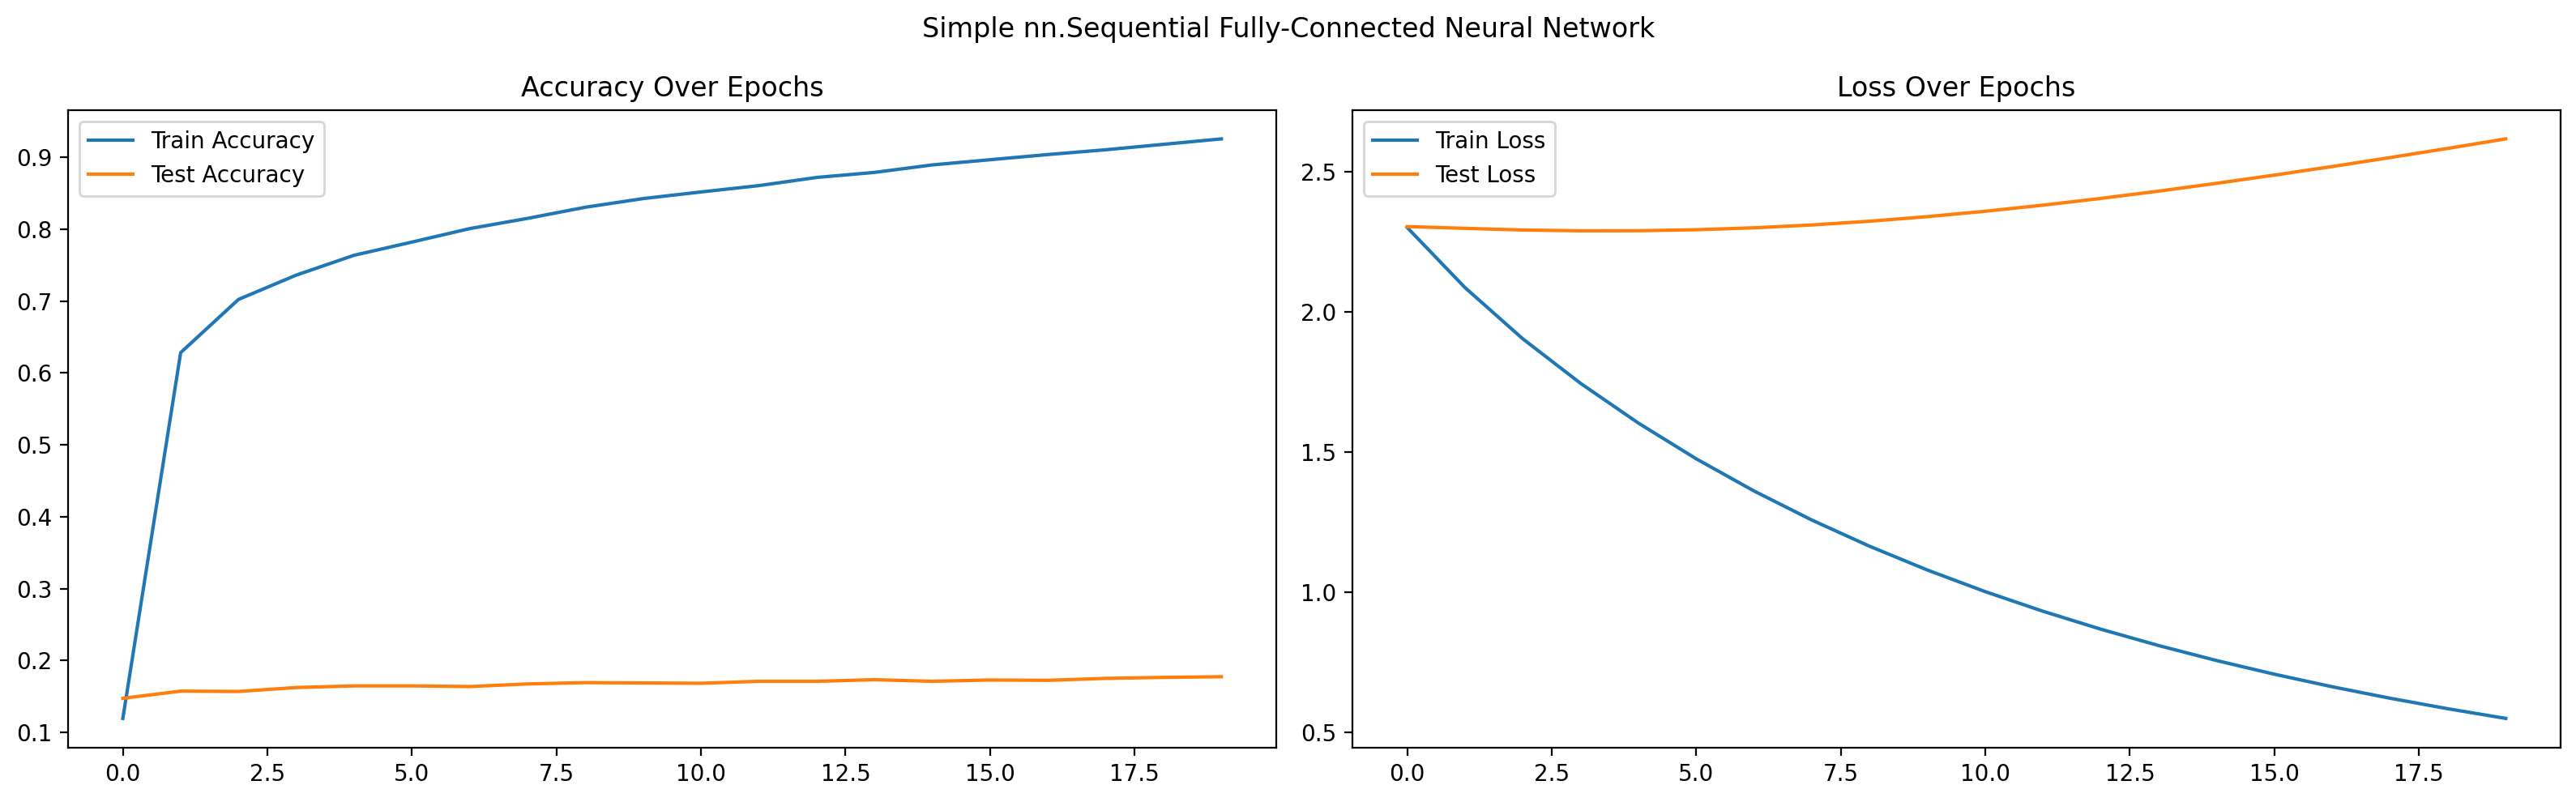

In [149]:
def convert_to_numpy(lst):
  new_lst = [elem.cpu().numpy() for elem in lst]
  return new_lst

train_accuracy_list_np = convert_to_numpy(train_accuracy_list)
test_accuracy_list_np = convert_to_numpy(test_accuracy_list)

fig, ax = plt.subplots(1, 2, figsize=(16, 5), dpi=200)

ax[0].plot(train_accuracy_list_np, label="Train Accuracy")
ax[0].plot(test_accuracy_list_np, label="Test Accuracy")
ax[0].set_title("Accuracy Over Epochs")
ax[0].legend()

ax[1].plot(train_loss_list, label="Train Loss")
ax[1].plot(test_loss_list, label="Test Loss")
ax[1].set_title("Loss Over Epochs")
ax[1].legend()

plt.suptitle("Simple nn.Sequential Fully-Connected Neural Network")
plt.tight_layout()

plt.savefig('sequential_nn.png')
plt.show()

In [150]:
print(test_accuracy_list_np[-1])

0.17751479


### Neural Network on Mel

In [151]:
# Model for mel representation
model = nn.Sequential(
    nn.Linear(in_features=11136, out_features=1500),
    nn.ReLU(),
    nn.Linear(in_features=1500, out_features=10),
)

In [152]:
with torch.no_grad():
    
    # convert our input data to a float tensor
    # cannot pass numpy array into pytorch, have to BOTH introduce with torch.tensor but ALSO
    # have to convert to float
    inputs = torch.tensor(Xtest_mel_flattened).float()
    
    # pass our inputs straight into the model
    preds = model(inputs)
    
    # determine what shape the predictions are so we know what to do with them
    print(f"Shape of preds: {preds.shape}")


    # no need to softmax the output since we will just take the argmax
    # argmax and softmax would have the same highest value
    preds = preds.argmax(1)
    
    # check test accuracy
    print(f"test accuracy: {torch.sum(preds == torch.tensor(y_mel_test)) / y_mel_test.shape[0]}")

Shape of preds: torch.Size([2197, 10])
test accuracy: 0.12517069280147552


In [153]:
# moving the model to right device
model.to(device)

# specify loss function
loss_func = nn.CrossEntropyLoss()

# define our optimizer 
# increasing lr from 1e-3 to 1e-1, then to 1e-5
# decreased weight decay to 1e-1
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [154]:
# metrics we want to collect
train_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
test_loss_list = []


# train for a given number of epochs
for epoch in tqdm.tqdm(range(20), desc="Epoch"):
        
    # get our input imgs and labels. We have to convert from NumPy (original) to torch.tensors()
    # PyTorch expects inputs as floats, and labels as longs (i.e., high-memory integers)
    inputs = torch.tensor(Xtrain_mel_flattened).float()
    labels = torch.tensor(y_mel_train).long()
    
    # move our inputs and labels to the right device.
    inputs, labels = inputs.to(device), labels.to(device)

    # reset the gradient 
    optimizer.zero_grad()
    
    # compute our forward propogation
    # outputs are not softmaxed
    outputs = model(inputs) 
    
    # calculate the cross-entropy loss
    # this automatically applies softmax
    loss = loss_func(outputs, labels) 
    
    # calculate backpropogation
    # takes the gradient of the loss function w.r.t. all the parameters
    loss.backward() 
    
    # make a small step update to our parameters
    optimizer.step() 
    

    # update our train_loss
    # only inclue the .item() to extract the pure value from the tensor
    train_loss_list.append(loss.item()) 

    # calculate + record our train + test accuracy. 
    # we have finished training here, only taking eval metrics
    with torch.no_grad():

        # get our predictions with the current weights
        # we only want the indices, not the values
        _, predicted = torch.max(outputs.data, 1)
        
        # get our train accuracy
        train_accuracy = torch.sum(predicted == labels) / labels.size(0)
        
        # add to our list of accuracies
        train_accuracy_list.append(train_accuracy)
            
        # get our test inputs and labels same process as earlier
        test_inputs = torch.tensor(Xtest_mel_flattened).float()
        test_labels = torch.tensor(y_mel_test).long()

        # move to the right device
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        # run our test set inputs through the network
        test_outputs = model(test_inputs)

        # get our test_loss
        test_loss = loss_func(test_outputs, test_labels)

        # record our test_loss
        # .item() tells pytorch we only want the value
        test_loss_list.append(test_loss.item())

        # make our predictions based on max
        _, test_predicted = torch.max(test_outputs.data, 1)

        # get our train accuracy
        test_accuracy = torch.sum(test_predicted == test_labels) / test_labels.size(0)
        
        # add to our list
        test_accuracy_list.append(test_accuracy)

Epoch: 100%|████████████████████████████████████| 20/20 [01:43<00:00,  5.17s/it]


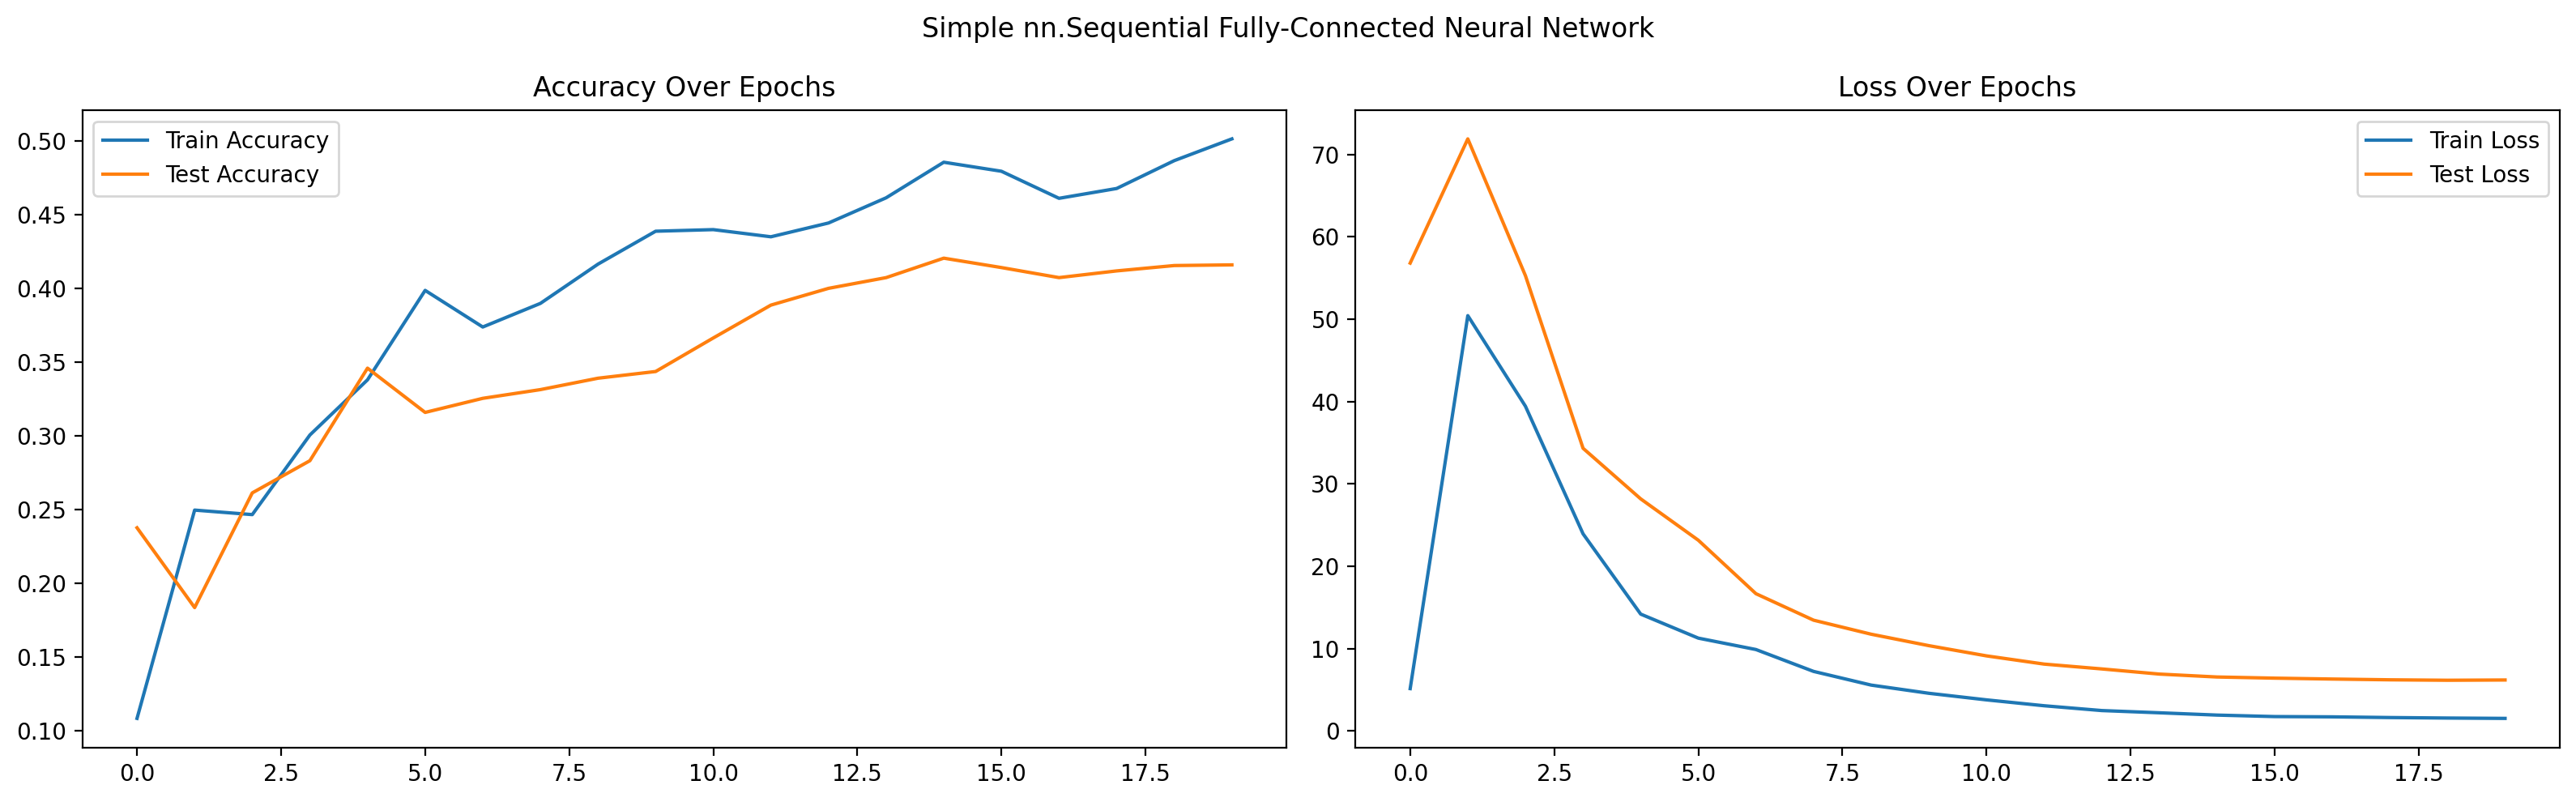

In [155]:
def convert_to_numpy(lst):
  new_lst = [elem.cpu().numpy() for elem in lst]
  return new_lst

train_accuracy_list_np = convert_to_numpy(train_accuracy_list)
test_accuracy_list_np = convert_to_numpy(test_accuracy_list)

fig, ax = plt.subplots(1, 2, figsize=(16, 5), dpi=200)

ax[0].plot(train_accuracy_list_np, label="Train Accuracy")
ax[0].plot(test_accuracy_list_np, label="Test Accuracy")
ax[0].set_title("Accuracy Over Epochs")
ax[0].legend()

ax[1].plot(train_loss_list, label="Train Loss")
ax[1].plot(test_loss_list, label="Test Loss")
ax[1].set_title("Loss Over Epochs")
ax[1].legend()

plt.suptitle("Simple nn.Sequential Fully-Connected Neural Network")
plt.tight_layout()

plt.savefig('sequential_nn.png')
plt.show()

In [156]:
print(test_accuracy_list_np[-1])

0.41602185


### Second Model: Random Forest

In [157]:
# On amp representation
from sklearn.ensemble import RandomForestClassifier
# Try out a random forest model for classification
# RandomForest
model = RandomForestClassifier(n_estimators=500, max_depth=None, n_jobs=-1)
model.fit(X_amp_train, y_amp_train)

# make our predictions
rf_preds = model.predict(X_amp_test)
print(np.mean(rf_preds == y_amp_test))

0.27901684114701863


In [158]:
# On mel representation
from sklearn.ensemble import RandomForestClassifier
# Try out a random forest model for classification
# RandomForest
model = RandomForestClassifier(n_estimators=500, max_depth=None, n_jobs=-1)
model.fit(Xtrain_mel_flattened, y_mel_train)

# make our predictions
rf_preds = model.predict(Xtest_mel_flattened)
print(np.mean(rf_preds == y_mel_test))

0.4729176149294492


### Third Model: SVM

In [165]:
from sklearn.svm import SVC

# create our SVM classifier
# C is proxy of soft or hard margin
model = SVC(C=2.0, kernel="rbf")

# SVM requires that each datapoint be a vector, and not a picture / matrix of pixels
# use Xtrain_mel_flattened from above
# fit our SVM model
model.fit(Xtrain_mel_flattened, y_mel_train)

# make our predictions
# must also use the Xtest_mel_flattened
SVM_preds = model.predict(Xtest_mel_flattened)
          
# calculate + print our accuracy
SVM_accuracy = np.mean(y_mel_test == SVM_preds)
print(SVM_accuracy)

0.2858443331816113


### B2: More Complicated Models-Hyperparameter Tuning and Validation

Perform a hyperparameter search to maximize predictive accuracy for two model classes of your choice. Choose which hyperparameters we search over, but must have at least 5 possible values for at least 1 hyperparameter.

### GridSearch for SVM

In [37]:
from sklearn.model_selection import GridSearchCV

In [27]:
# Grid search for mel!
# these are the settings that we will tune: 'C', 'kernel'
param_grid = {'C' : [0.1, 0.5, 1.0], 
              'kernel' : ['rbf', 'sigmoid'],}

SVM = SVC()

# instantiate our gridsearch estimator
# cv=None defaults to the 5-fold cross validation
SVM_CV = GridSearchCV(estimator=SVM, param_grid=param_grid, n_jobs=-1, cv=None, verbose=1)
SVM_CV.fit(Xtrain_mel_flattened, y_mel_train)

# for each of possible combinations, fits 5 folds for each of 10 candidates, for a total of 50 fits

# convert our results to a pd.DataFrame
SVM_results = pd.DataFrame(SVM_CV.cv_results_).sort_values(by=['rank_test_score'])
SVM_results.head(5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,423.170185,39.007777,104.337111,17.254545,1.0,rbf,"{'C': 1.0, 'kernel': 'rbf'}",0.298830,0.272727,0.263726,0.262162,0.271171,0.273723,0.013202,1
2,459.131023,9.416123,117.805390,9.498463,0.5,rbf,"{'C': 0.5, 'kernel': 'rbf'}",0.298830,0.240324,0.204320,0.235135,0.251351,0.245992,0.030683,2
5,300.837470,23.282034,38.248458,8.269776,1.0,sigmoid,"{'C': 1.0, 'kernel': 'sigmoid'}",0.220522,0.207921,0.186319,0.185586,0.222523,0.204574,0.016009,3
3,428.682019,14.949805,69.492418,7.954260,0.5,sigmoid,"{'C': 0.5, 'kernel': 'sigmoid'}",0.208821,0.188119,0.154815,0.176577,0.193694,0.184405,0.018072,4
0,540.388693,1.278154,109.777509,1.510208,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.216922,0.166517,0.173717,0.173874,0.187387,0.183683,0.017937,5


### GridSearch for RandomForest

In [126]:
# Grid search for mel!
param_grid = {'n_estimators' : [50, 100, 500, 1000], 
              'max_depth' : [5, 10],}

# instantiate the model
RF= RandomForestClassifier()

# instantiate our gridsearch estimator
RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, n_jobs=-1, cv=None, verbose=1)
RF_CV.fit(Xtrain_mel_flattened, y_mel_train)

# convert results to pd.DataFrame
RF_results = pd.DataFrame(RF_CV.cv_results_).sort_values(by=['rank_test_score'])
RF_results.head(5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,321.543897,23.458783,0.407817,0.040447,10,1000,"{'max_depth': 10, 'n_estimators': 1000}",0.464446,0.543654,0.525653,0.508108,0.476577,0.503688,0.029578,1
5,41.426705,0.216130,0.082071,0.001900,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.487849,0.540954,0.520252,0.493694,0.473874,0.503324,0.024092,2
6,204.671585,1.193247,0.307912,0.030252,10,500,"{'max_depth': 10, 'n_estimators': 500}",0.465347,0.539154,0.519352,0.500901,0.468468,0.498644,0.028616,3
4,21.062514,0.570693,0.047838,0.003148,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.468947,0.524752,0.522052,0.496396,0.471171,0.496664,0.023882,4
2,137.306940,0.605890,0.248057,0.030852,5,500,"{'max_depth': 5, 'n_estimators': 500}",0.430243,0.439244,0.416742,0.363063,0.413514,0.412561,0.026431,5


# Part C

## CNN on Spectogram Data

In [160]:
# inherits the nn.Module class
class CNN(nn.Module):
    # only need the constructor for what layers you want 
    # and forward for how you want to feed forward
    # everything else for backprop, etc is inherited from nn.Module
    
    # constructor
    def __init__(self):
        
        # call the parent constructor (for nn.Module)
        super().__init__()
        
        ## first set of convolution + pooling: see documentation about specifics
        # conv2d = built in CNN
        # out_channels = we will find 16 filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        
        ## to increase robustness ... again, this is optional reading
        self.pool1 = nn.MaxPool2d(2)
        
        # second set of convolution + pooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        
        # dropout layer to randomly drop neurons: for regularization
        # randomly drops out parameters so that we don't overfit
        self.dropout = nn.Dropout()
        
        ## end with three linear layers, this is general practice
        self.fc1 = nn.Linear(19200, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 10)
    
    # define how the neural network processes ONE data point (which generalizes instantly into a whole dataset)
    # aka: given x, how do we get the output? Just pass it through the layers.
    def forward(self, x):
        # first set of convolution + pooling
        x = self.conv1(x)
        x = self.pool1(x)
        x = torch.relu(x)
        
        # second set of convolution + pooling
        x = self.conv2(x)
        x = self.pool2(x)
        x = torch.relu(x)
        
        # the drop out layer
        x = self.dropout(x)
        
        # flatten + linear layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        
        return x

In [161]:
# instantiate our model
model_cnn = CNN()

# moving the model to right device
model_cnn.to(device)

# specify our loss function
loss_func = nn.CrossEntropyLoss()

# define our optimizer - could also do Adam, RMSprop, SGD
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3, weight_decay=1e-4)

In [162]:
Xtrain_mel_nn = X_mel_train.reshape(-1, 1, 128, 87)
Xtest_mel_nn = X_mel_test.reshape(-1, 1, 128, 87)

In [166]:
# metrics we want to collect
train_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
test_loss_list = []

# torch.cuda.reset_max_memory_allocated()
# torch.cuda.reset_max_memory_cached()
# torch.cuda.empty_cache()
# torch.backends.cudnn.deterministic=True
# torch.backends.cudnn.benchmark=True

# train for a given number of epochs
for epoch in tqdm.tqdm(range(20), desc="Epoch"):
        
    # query data for inputs (images) + labels: [inputs, labels]
    inputs = torch.tensor(Xtrain_mel_nn).float()
    labels = torch.tensor(y_mel_train).long()
    
    # move to the right device.
    inputs, labels = inputs.to(device), labels.to(device)

    # reset the gradient
    optimizer.zero_grad()

    # forward prop, backward prop, make incremental step
    outputs = model_cnn(inputs) # implicitly calls the .forward() function
    loss = loss_func(outputs, labels) # calculate the loss
    loss.backward() # calculate the gradient
    optimizer.step() # take our incremental update of the parameters

    # update our train_loss
    train_loss_list.append(loss.item()) 

    # calculate + record our train + test accuracy (TRAINING!)
    with torch.no_grad():

        # get our predictions with the current weights: torch.max returns values, indices
        _, predicted = torch.max(outputs.data, 1)
        
        # get our train accuracy
        train_accuracy = torch.sum(predicted == labels) / labels.size(0)
        
        # add to our list
        train_accuracy_list.append(train_accuracy)
            
        # get our test inputs and labels
        test_inputs = torch.tensor(Xtest_mel_nn).float()
        test_labels = torch.tensor(y_mel_test).long()

        # move to the right device
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        # run our test set inputs through the network
        test_outputs = model_cnn(test_inputs)

        # get our test_loss
        test_loss = loss_func(test_outputs, test_labels)

        # record our test_loss
        test_loss_list.append(test_loss.item())

        # make our predictions based on max.
        _, test_predicted = torch.max(test_outputs.data, 1)

        # get our train accuracy
        test_accuracy = torch.sum(test_predicted == test_labels) / test_labels.size(0)
        
        # add to our list
        test_accuracy_list.append(test_accuracy)

Epoch: 100%|████████████████████████████████████| 20/20 [11:51<00:00, 35.59s/it]


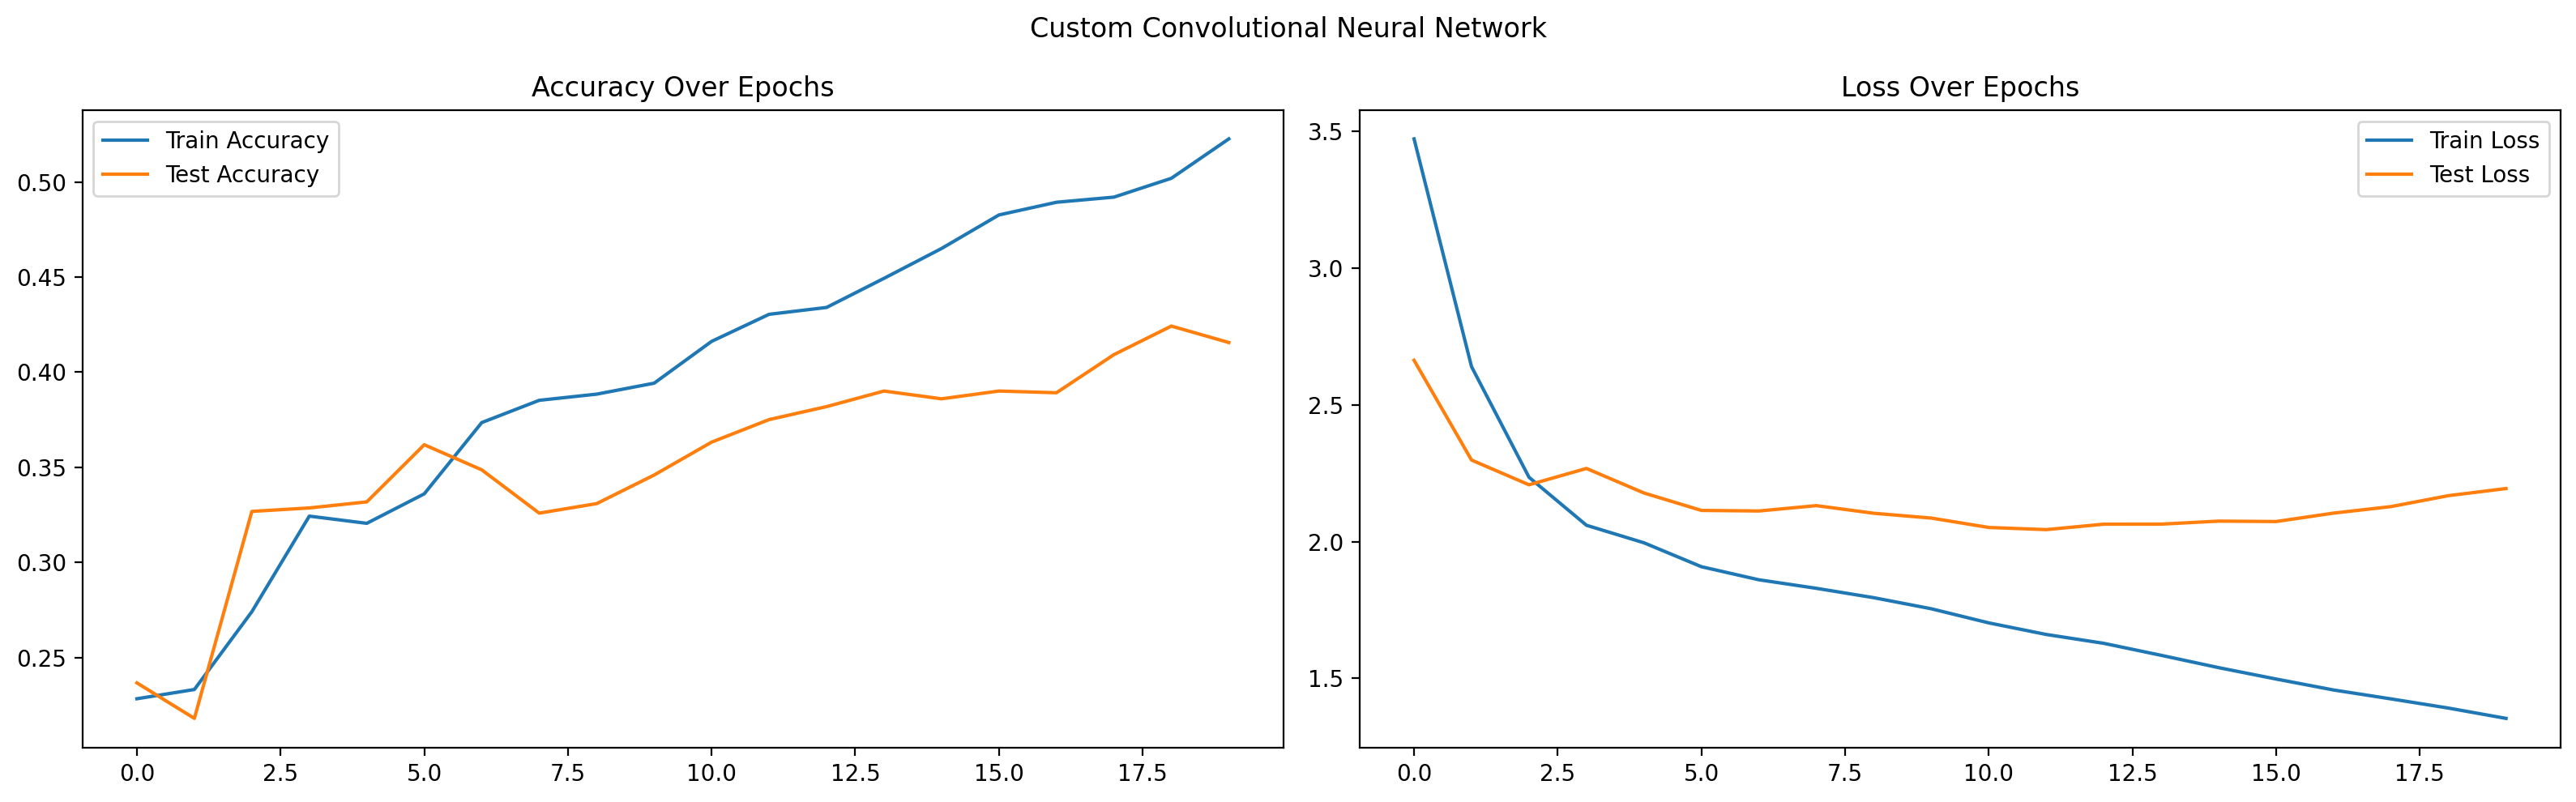

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), dpi=200)

ax[0].plot(train_accuracy_list, label="Train Accuracy")
ax[0].plot(test_accuracy_list, label="Test Accuracy")
ax[0].set_title("Accuracy Over Epochs")
ax[0].legend()

ax[1].plot(train_loss_list, label="Train Loss")
ax[1].plot(test_loss_list, label="Test Loss")
ax[1].set_title("Loss Over Epochs")
ax[1].legend()

plt.suptitle("Custom Convolutional Neural Network")
plt.tight_layout()
plt.savefig('cnn_accuracy_loss.png')
plt.show()

In [168]:
# make our test predictions with NO GRADIENT!
with torch.no_grad():
    
    # set our model to evaluation mode
    # don't do anything but make predictions from here on
    model_cnn.eval()
    
    # get our test inputs and labels
    test_inputs = torch.tensor(Xtest_mel_nn).float()
    test_labels = torch.tensor(y_mel_test).long()
    
    # make our predictions and get the integer classes using argmax this time
    # find the biggest value for that class
    ypreds_test = model_cnn(test_inputs).argmax(dim=1)
    
    # convert our predictions into numpy
    # detach function removes what we just calcualted and jut gives us the value
    # need to convert back to numpy for everything to play nicely together bc sklearn is where 
    # a lot of our metrix are
    ypreds_test = ypreds_test.detach().numpy()
    
# calculate our test accuracy
print(f"Accuracy: {np.mean(ypreds_test == y_mel_test)}")

Accuracy: 0.41420118343195267


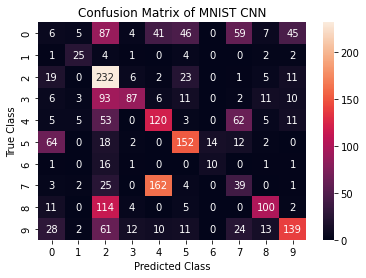

In [169]:
# compute + display our confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure()
cfm = confusion_matrix(y_mel_test, ypreds_test)
sns.heatmap(cfm, annot=True, fmt='g')
plt.title("Confusion Matrix of MNIST CNN")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig('cnn_confusion_matrix.png')
plt.show()